# **NOTEBOOK PLS**

Al momento potresti cominciare in modo semplice con il segnale BOLD provando la seguente cosa per uno dei film (poi puoi andare per tutti i 14):
- **X = Nsubjs x N_brain_features** =  Matrice contenente per ogni soggetto  il vettore di upper triangular values dei connettomi di ciascun soggetti <br>
/media/miplab-nas2/Data2/Movies_Emo/Flavia_E3/Data/TC_114*)
- **Y = Nsubjs x N_behavioural_features** = Matrice contenente per ogni soggetto i behaviour  <br>
/media/miplab-nas2/Data2/Movies_Emo/BIDS/TheRealfMRIStudy/rawdata/participants.tsv <br>


In [4]:
import pandas as pd
#from plot import *
from compute import *
import seaborn as sns
import matplotlib.pyplot as plt
import h5py

Read the data

In [3]:
# Load the Y behavioural dataset
PATH_DATA = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/'
columns = ['DASS_dep', 'DASS_anx', 'DASS_str',	'bas_d', 'bas_f', 'bas_r', 'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope']

Y = pd.read_csv(PATH_DATA + 'participants.tsv', sep='\t', header=0)[columns]
print('The shape of the Y behavioural dataset is: ', Y.shape)
Y.head()

The shape of the Y behavioural dataset is:  (30, 12)


,DASS_dep,DASS_anx,DASS_str,bas_d,bas_f,bas_r,bis,BIG5_ext,BIG5_agr,BIG5_con,BIG5_neu,BIG5_ope
0,0,2,1,3.50,3.25,4.0,2.857143,31,40,34,27,40
1,1,0,0,3.50,2.75,3.0,2.142857,29,32,35,19,36
2,4,7,14,2.50,3.25,3.2,3.285714,22,29,32,26,47
3,0,2,2,3.25,3.00,3.8,3.285714,35,45,43,21,42
4,5,2,9,3.25,3.50,3.0,3.285714,21,36,30,22,42


In [4]:
def bootstrap_data(list_methods, list_functionalnetworks, verbose = False):
    
    df_bootstrap = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
    for method in list_methods: 
        
        df_fn = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
        for fn in list_functionalnetworks:
            if verbose:
                print(method, fn)
            
            PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_bootstrap/PLS_{method}_{fn}_bootstrap_results.csv'
            df = pd.read_csv(PATH, index_col=0).reset_index()

            # add the bootstrap round columns
            n_movies = df.Movie.unique()
            a = np.repeat(np.arange(1,101), df.shape[0] / 100 / len(n_movies))
            for i in range(n_movies.shape[0]-1):
                a = np.concatenate((a, np.repeat(np.arange(1,101), df.shape[0] / 100 / len(n_movies))), axis = 0)

            df['bootstrap_round'] = a

            df['Type'] = f'{method}'
            significant = df[df['P-value'] <= 0.05]

            notin = [x for x in list_movies if x not in significant.Movie.unique()]
            for movie in notin:
                new_row = {'Movie': f'{movie}', 'P-value': 0.0, 'Covariance Explained': 0.0, 'Type': f'{method}', 'LC': '1', 'Region': f'{fn}'}
                significant =  pd.concat([significant, pd.DataFrame([new_row])], ignore_index=True)
                if verbose:
                    print('added: ', movie)

            df_lc = significant.groupby(['Movie', 'bootstrap_round', 'Region', 'Type']).sum().reset_index()
            df_fn = pd.concat([df_fn, df_lc], ignore_index=True)
        
        df_bootstrap = pd.concat([df_bootstrap, df_fn], ignore_index=True)

    df_bootstrap['Movie_Type'] = df_bootstrap['Movie'] + '_' + df_bootstrap['Type']
    df_bootstrap = df_bootstrap.sort_values(by=['Movie_Type', 'Region', 'Type'])

    return df_bootstrap

We nwo created the X and Y matrices. It's now time to compute the PLSC behavioural algorithm. <br>

**PLS** is a multivariate method that finds linear combinations of the two matrices that are maximally correlated. <br>
The algorithm is as follows: <br>

0. Normalize and centre the data: **X_n = X - mean(X)** and **Y_n = Y - mean(Y)** 
1. Compute the covariance matrix between X and Y: **R_beh_n = YT_beh_n • X_n**
2. Compute the SVD of R_beh_n: **R_beh_n = U_beh_n • S_beh_n • V_beh_nT**
3. From the saliences **U_beh_n** and **V_beh_nT** compute the latent variables **LV_beh_n = U_beh_n • S_beh_n** and **LV_brain_n = V_beh_nT • S_beh_n**
4. Use PCA to reduce the dimensionality of the latent variables **LV_beh_n** and **LV_brain_n**


The PLS was already computed for you and saved in the folder: <br>
**'/Users/silviaromanato/Desktop/ServerMIPLAB/Silvia/Data/Output'**

In [5]:
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Rest', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']

## **ALL YEO NETWORKS; CONCAT MOVIES**

In [6]:
df_all = pd.DataFrame(columns = ['P-value', 'Covariance Explained', 'Type', 'Region'])
list_functionalnetworks = ['ALL', 'DA', 'DMN', 'FP', 'L', 'SC', 'SM', 'VA', 'VIS']

for method in ['bold']:

    df_fn = pd.DataFrame(columns = ['P-value', 'Covariance Explained', 'Type', 'Region'])
    for fn in list_functionalnetworks:
        PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_{method}_{fn}_concatmovies.csv'
        df = pd.read_csv(PATH, index_col=0).reset_index()
        if df.shape[0] == 0:
            df = pd.DataFrame({'P-value': 0.0, 'Covariance Explained' : 0.0, 'Type': 'bold', 'Region': fn}, index=[0])
        df['Type'] = f'{method}'
        df['Region'] = f'{fn}'
        significant = df[df['P-value'] <= 0.05][['P-value', 'Covariance Explained', 'Type', 'Region']]
        df_fn = pd.concat([df_fn, significant], ignore_index=True)
            
    df_all = pd.concat([df_all, df_fn], ignore_index=True)

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 2000x1000 with 0 Axes>

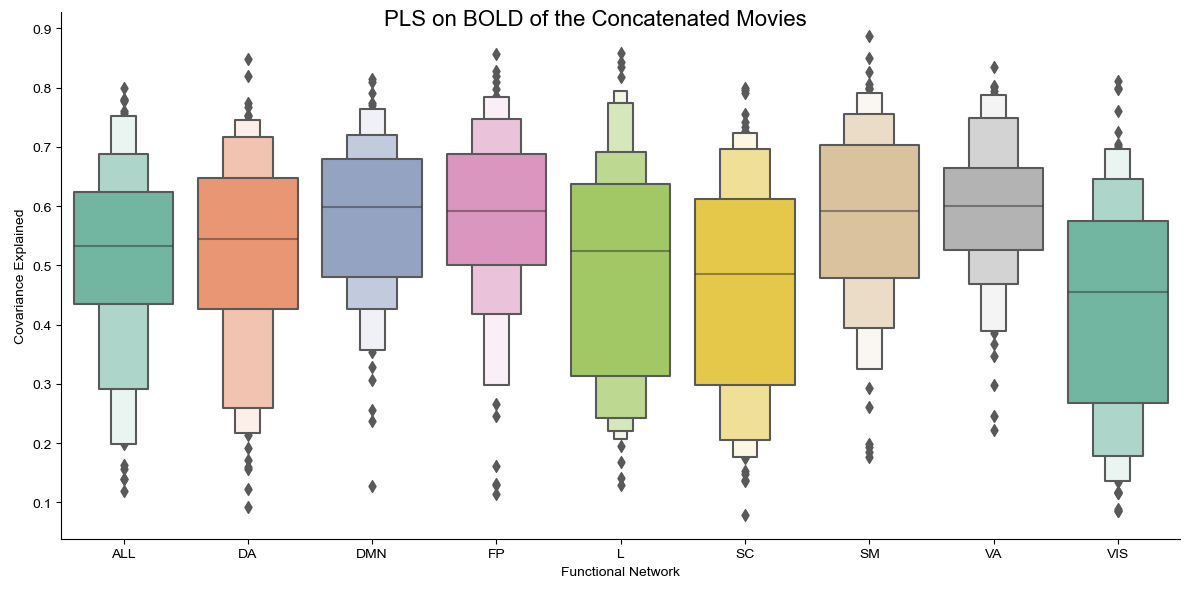

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = sns.color_palette("Set2")
plt.figure(figsize=(20, 10))
g = sns.catplot(data=df_all, x='Region', y='Covariance Explained', kind = 'boxen', height=6,
                aspect=2, palette=palette)
g.fig.suptitle('PLS on BOLD of the Concatenated Movies', fontsize=16)
g.set(xlabel='Functional Network', ylabel='Covariance Explained')
sns.set_style("whitegrid")
plt.show()

## **BOOTSTRAPPING whole brain**

In [11]:
list_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 'LessonLearned', 'Payload', 'Rest', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain']

list_functionalnetworks = ['ALL']
list_methods = ['bold', 'scaffold', 'triangles']

df_bootstrap = bootstrap_data(list_methods, list_functionalnetworks)

/Users/silviaromanato/.conda/envs/silviasenv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_15855/3074760352.py:10: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.stripplot(data=df_bootstrap, x='Movie', y='Covariance Explained', hue='Type', dodge=True, size=5, palette=palette, order=order_movies)


<Figure size 1000x1000 with 0 Axes>

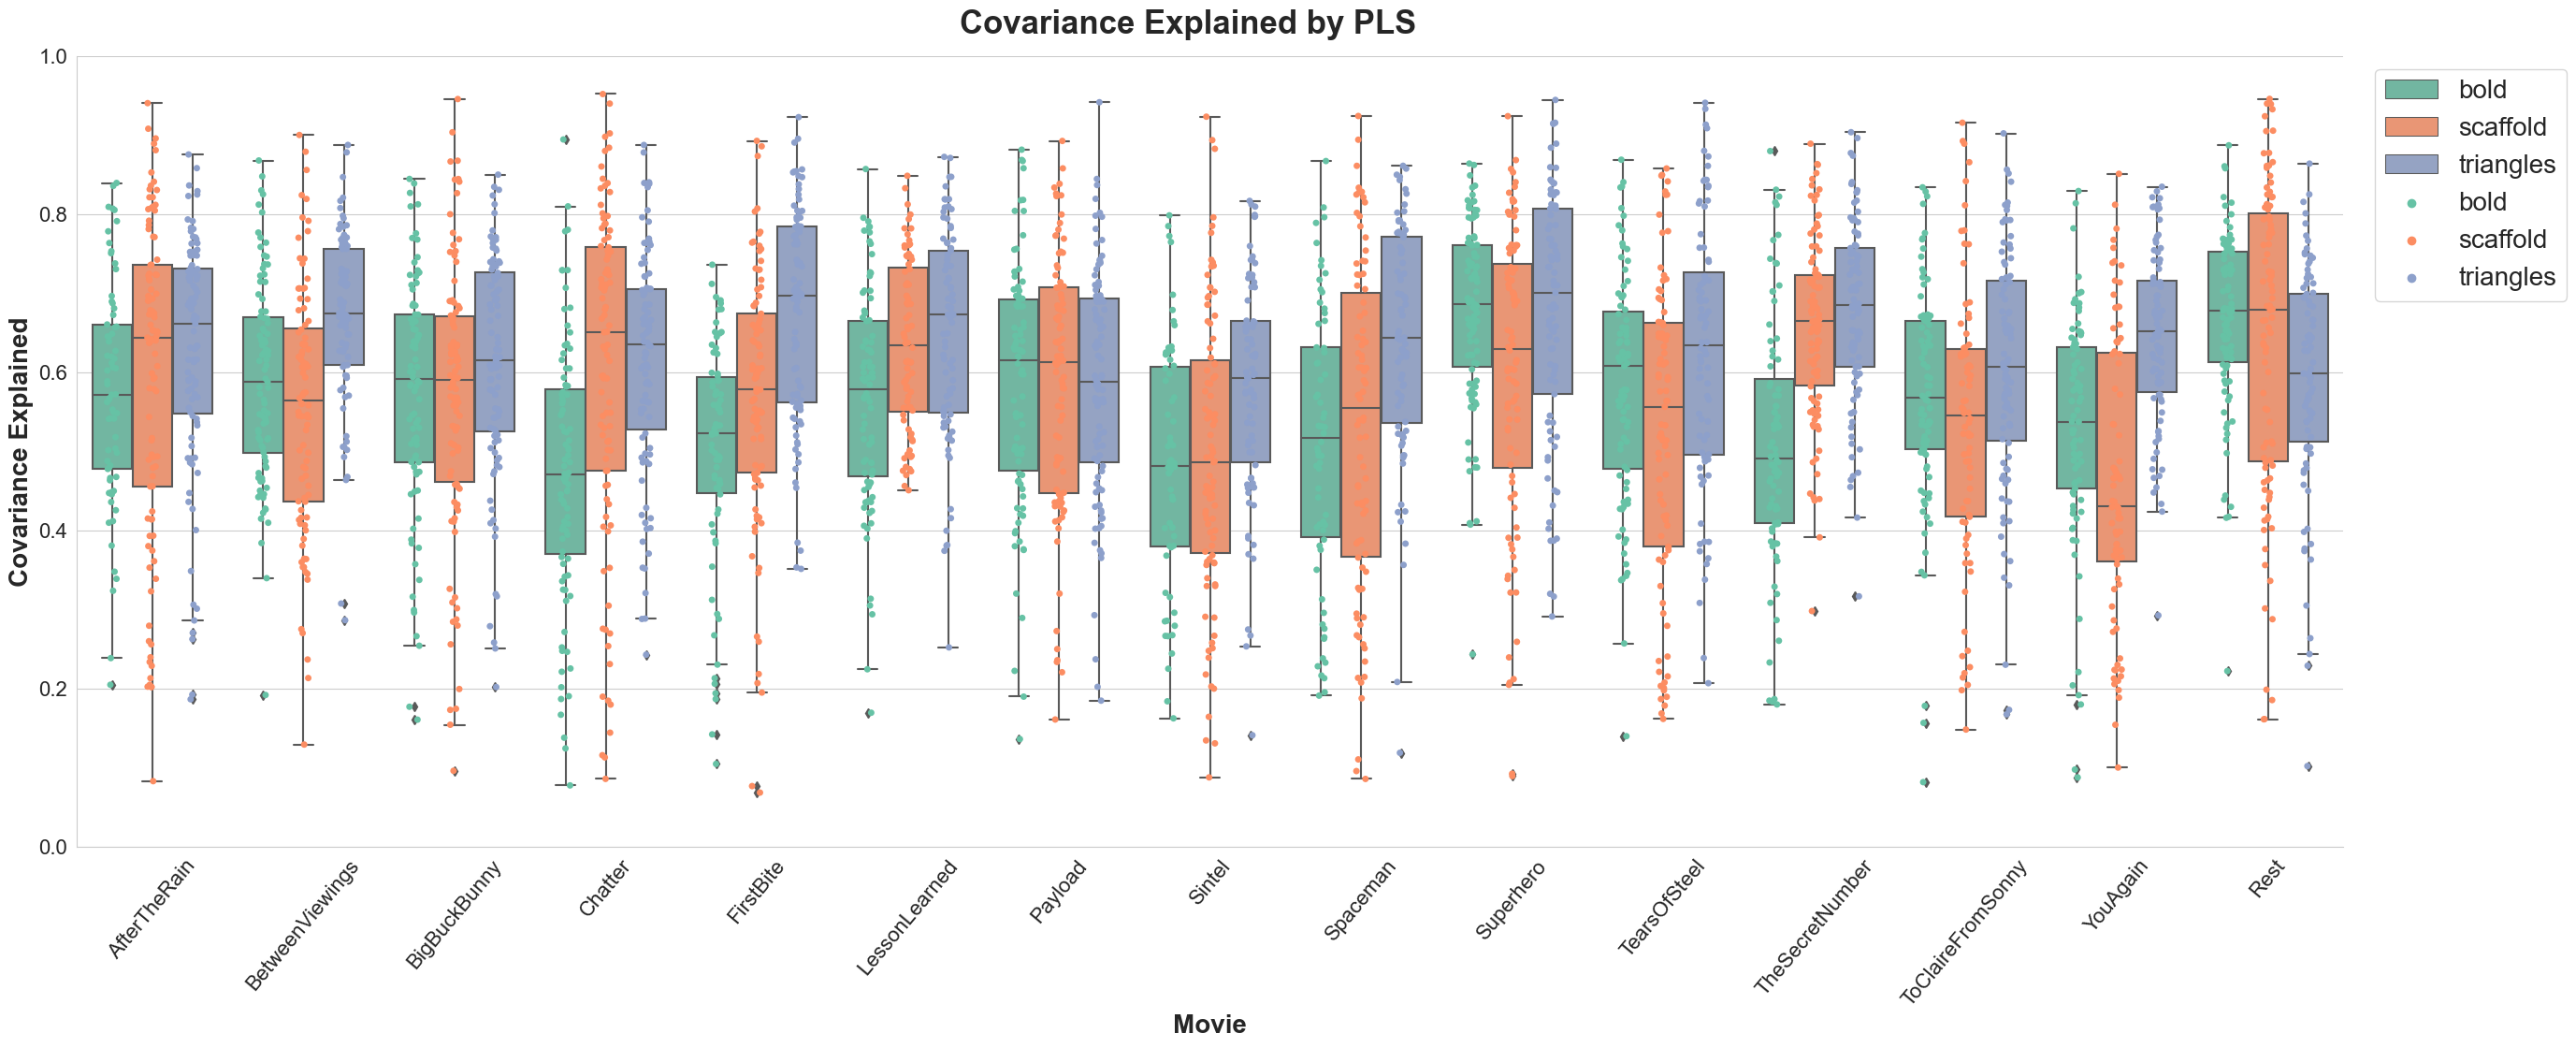

In [12]:
palette = sns.color_palette("Set2")
plt.figure(figsize=(10, 10))
plt.tight_layout()
order_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 
                'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 
                'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain', 'Rest']

g = sns.catplot(data=df_bootstrap, x='Movie', y='Covariance Explained', hue='Type', kind='box', height=10,
                aspect= 2.5, palette=palette, order=order_movies, legend_out=False)
sns.stripplot(data=df_bootstrap, x='Movie', y='Covariance Explained', hue='Type', dodge=True, size=5, palette=palette, order=order_movies)

g.set_xticklabels(rotation=50, fontsize=16)
g.set_yticklabels(fontsize=16)
g.fig.suptitle('Covariance Explained by PLS', fontsize=25, fontweight='bold', y=0.95)
g.fig.subplots_adjust(top=0.9)
g.set_axis_labels("Movie", "Covariance Explained", fontsize=20, fontweight='bold')
sns.set_style("whitegrid")
plt.ylim(0, 1.00)
g._legend.remove()
g.fig.legend(loc='upper right', bbox_to_anchor=(1.095, 0.9), fontsize=20)

plt.show()


## **BOOTSTRAPPING ON YEO NETWORKS**

In [10]:
df_all = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
list_functionalnetworks = ['DA', 'DMN', 'VIS', 'FP', 'SM', 'VA','L', 'SC']

for method in ['bold', 'triangles', 'scaffold']:

    df_fn = pd.DataFrame(columns = ['Movie', 'P-value', 'Covariance Explained', 'Type', 'LC', 'Region'])
    for fn in list_functionalnetworks:
        PATH = f'/Users/silviaromanato/Desktop/SEMESTER_PROJECT/Material/Output/PLS_csv/PLS_{method}_{fn}_results.csv'
        df = pd.read_csv(PATH)
        df = df.drop_duplicates(subset = ['Movie', 'LC'])

        # add the bootstrap round columns
        n_movies = df.Movie.unique()
        a = np.repeat(np.arange(1,101), 12)
        for i in range(n_movies.shape[0]-1):
            a = np.concatenate((a, np.repeat(np.arange(1,101), 12)), axis = 0)
        df['bootstrap_round'] = a
        df['Type'] = f'{method}'
        df['Region'] = f'{fn}'

        significant = df[df['P-value'] < 0.05]

        notin = [x for x in list_movies if x not in significant.Movie.unique()]

        for movie in notin:
            new_row = {'Movie': f'{movie}', 'P-value': 0.0, 'Covariance Explained': 0.0, 'Type': f'{method}', 'LC': '1', 'Region': f'{fn}'}
            significant =  pd.concat([significant, pd.DataFrame([new_row])], ignore_index=True)
            #print('added: ', movie)

        df_fn = pd.concat([df_fn, significant], ignore_index=True)
            
    df_all = pd.concat([df_all, df_fn], ignore_index=True)


df_all = df_all.sort_values(by=['Movie', 'Region', 'Type'])
df_all = df_all.groupby(['Movie', 'Region', 'Type'])[['Covariance Explained', 'P-value']].sum().reset_index()

ValueError: Length of values (18000) does not match length of index (180)

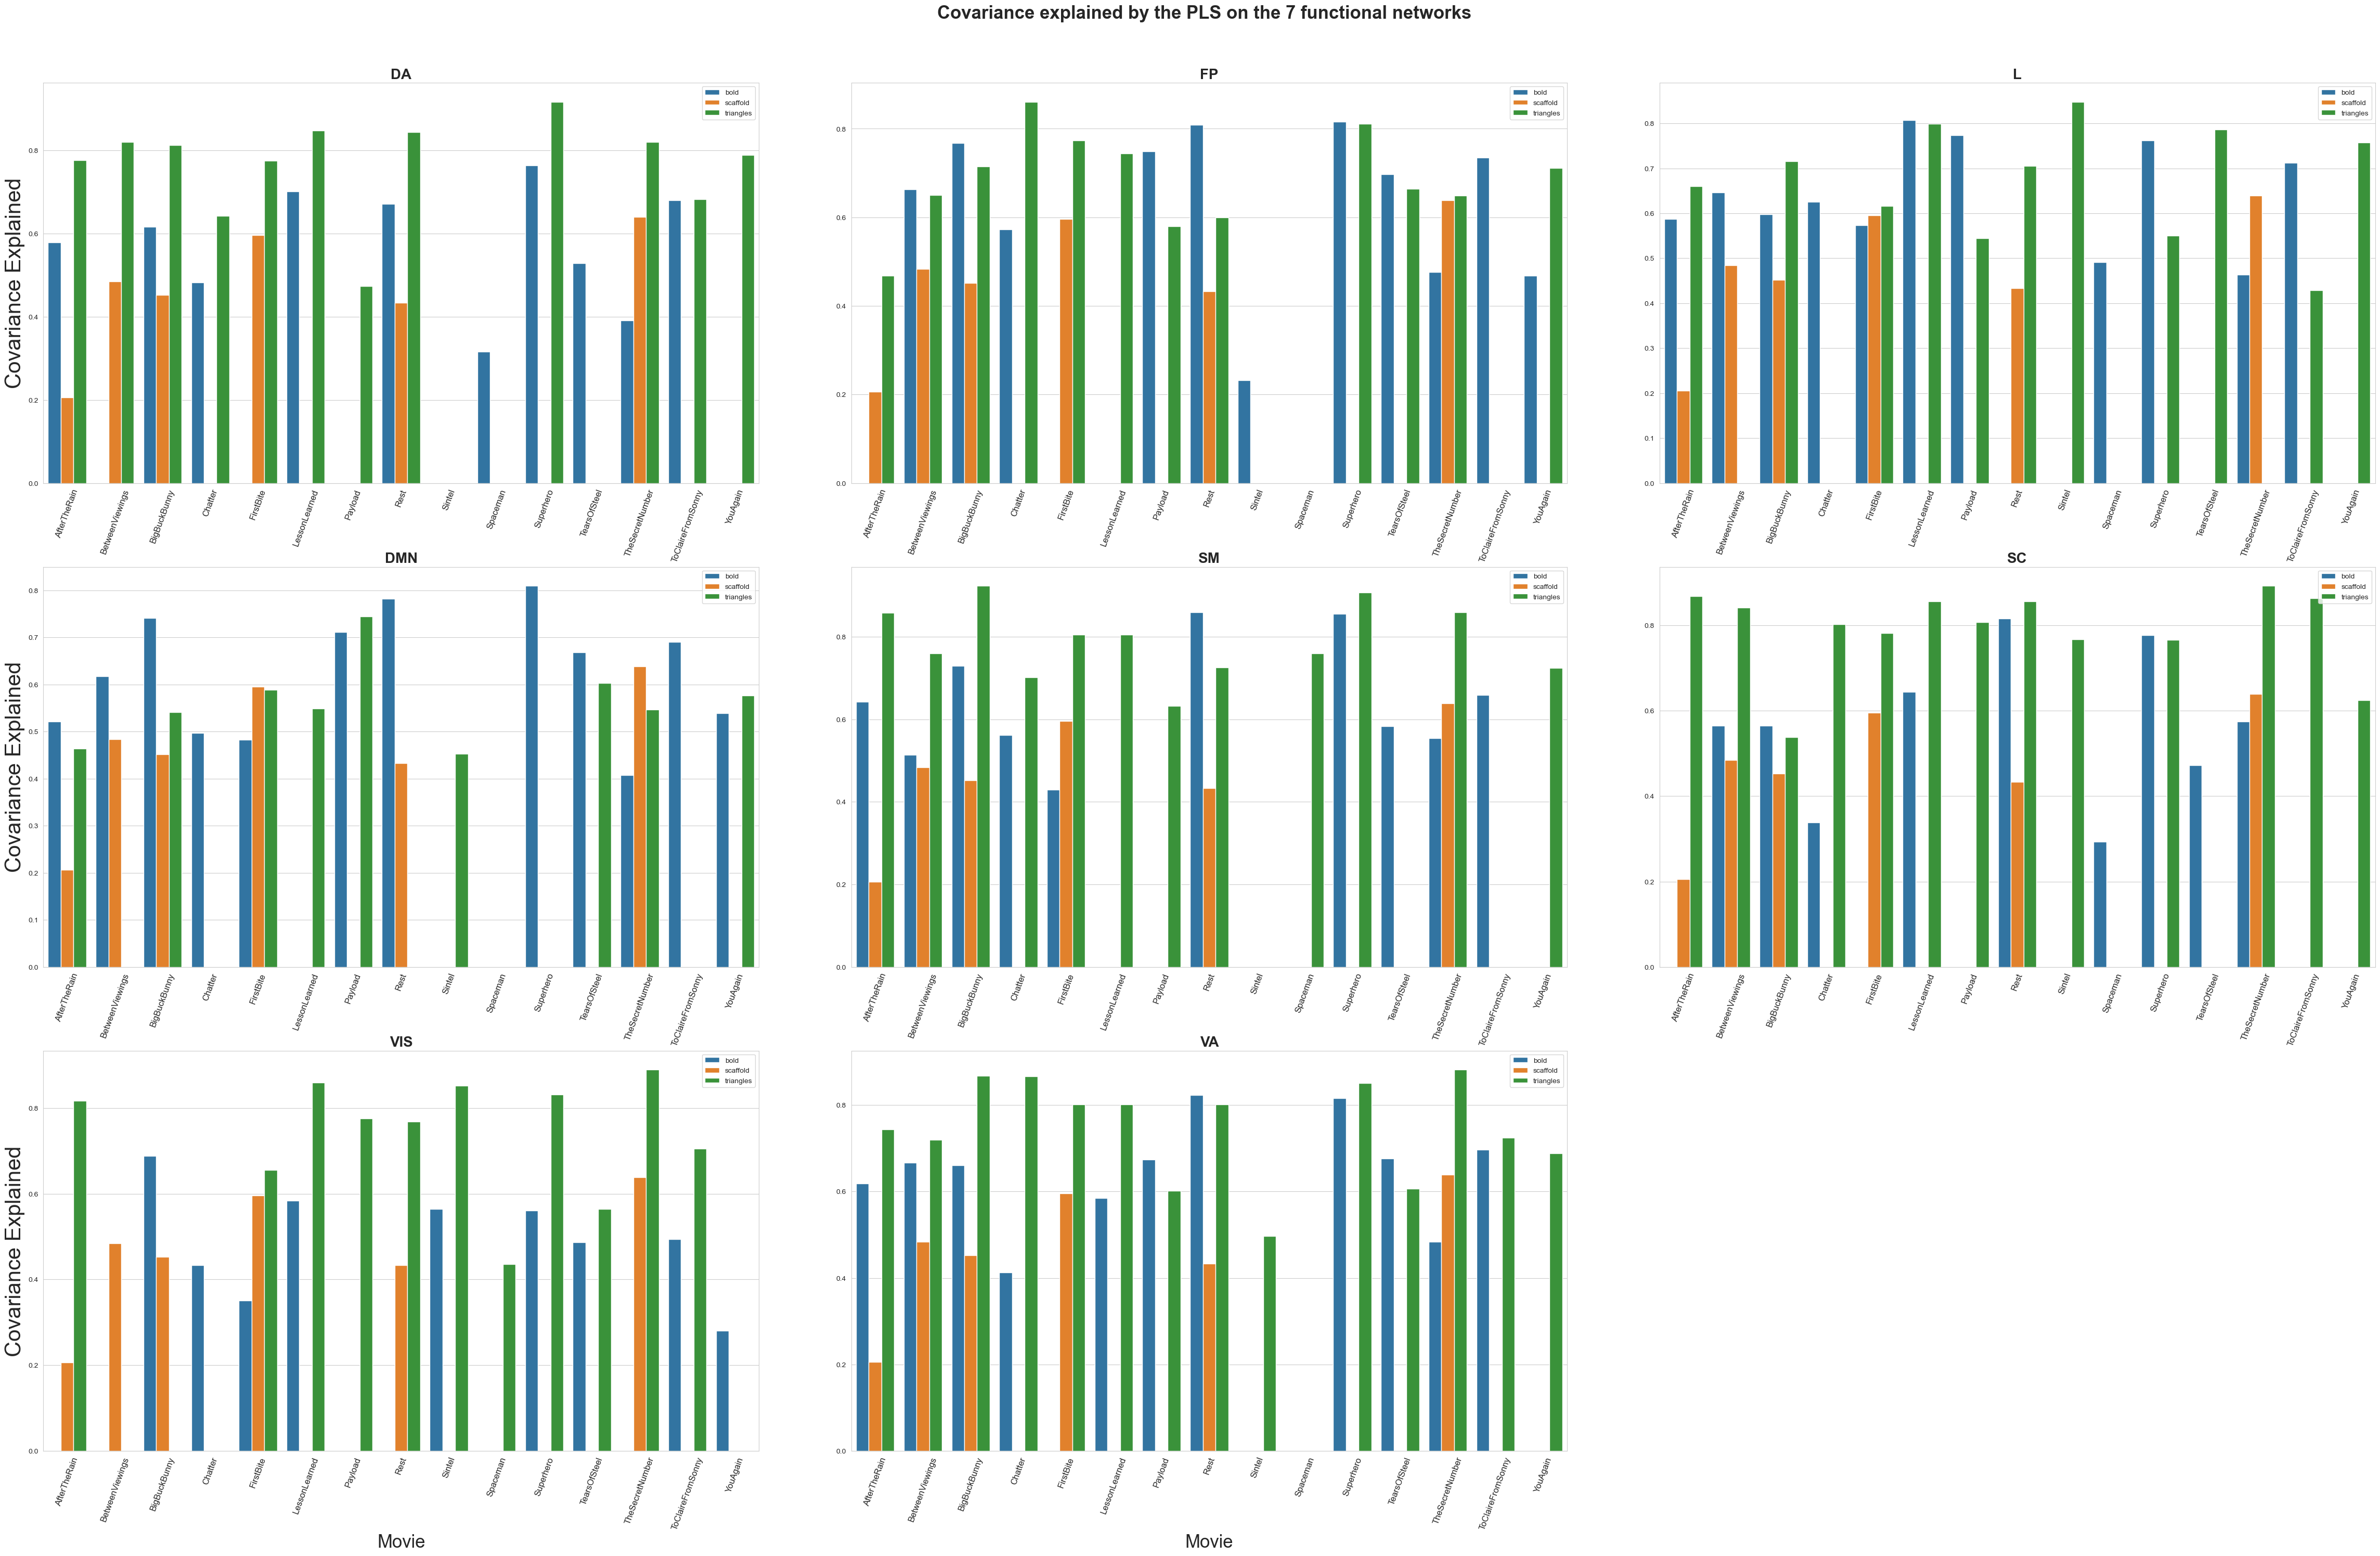

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(len(list_functionalnetworks) * 6, 30))
palette = sns.color_palette("Set2")
axes[2, 2].remove()
fig.tight_layout(pad=10)
for i, network in enumerate(list_functionalnetworks):
    row = i % 3
    col = i // 3
    network_df = df_all[df_all['Region'] == network]

    ########### PLOT ###########
    sns.barplot(network_df, ax = axes[row, col], x='Movie', y='Covariance Explained', hue='Type')
    # remove the x labels and the y labels
    axes[row, col].set_xlabel('')
    axes[row, col].set_ylabel('')
    axes[row, col].set_title(network, fontsize=20, fontweight='bold')
    if row == 2:
        axes[row, col].set_xlabel('Movie', fontsize=25)
    if row == 1 & col == 2:
        axes[row, col].set_xlabel('Movie', fontsize=25)
    if col == 0:
        axes[row, col].set_ylabel('Covariance Explained', fontsize=30)
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=70, fontsize=12)
    axes[row, col].legend(loc='upper right')

fig.suptitle('Covariance explained by the PLS on the 7 functional networks', fontsize=25, fontweight='bold')
plt.subplots_adjust(top=0.93)


## Bootstrap

In [13]:
list_methods = ['bold', 'scaffold', 'triangles']
list_functionalnetworks = ['DA', 'DMN', 'FP', 'SC', 'SM', 'VA', 'VIS', 'L']

df_bootstrap = bootstrap_data(list_methods, list_functionalnetworks)

/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_15855/4105787788.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=18)
/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_15855/4105787788.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=18)


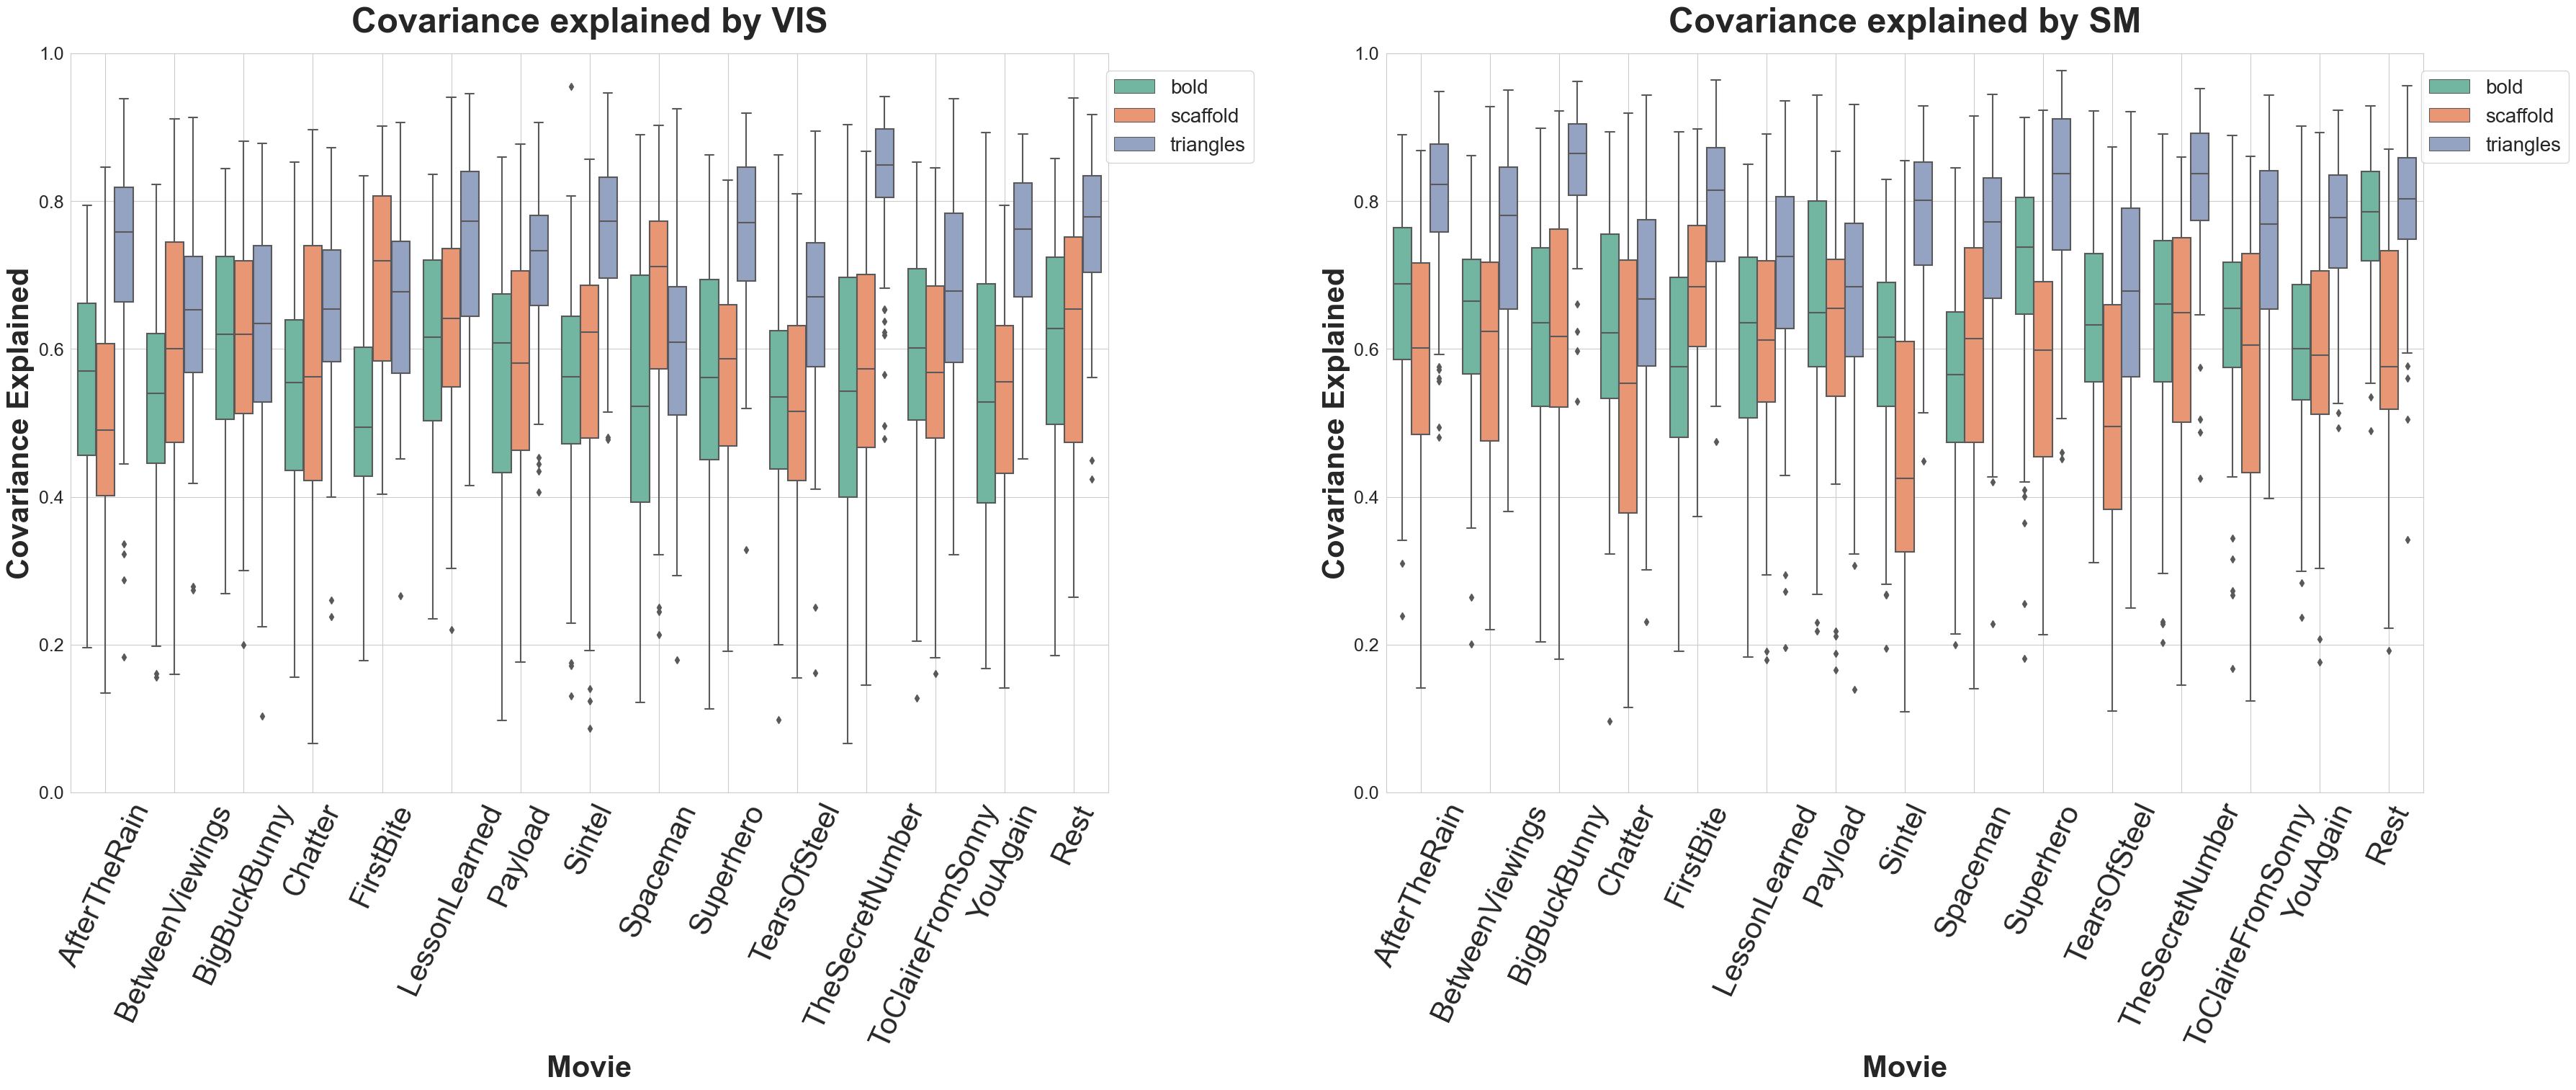

/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_15855/4105787788.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=18)
/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_15855/4105787788.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=18)


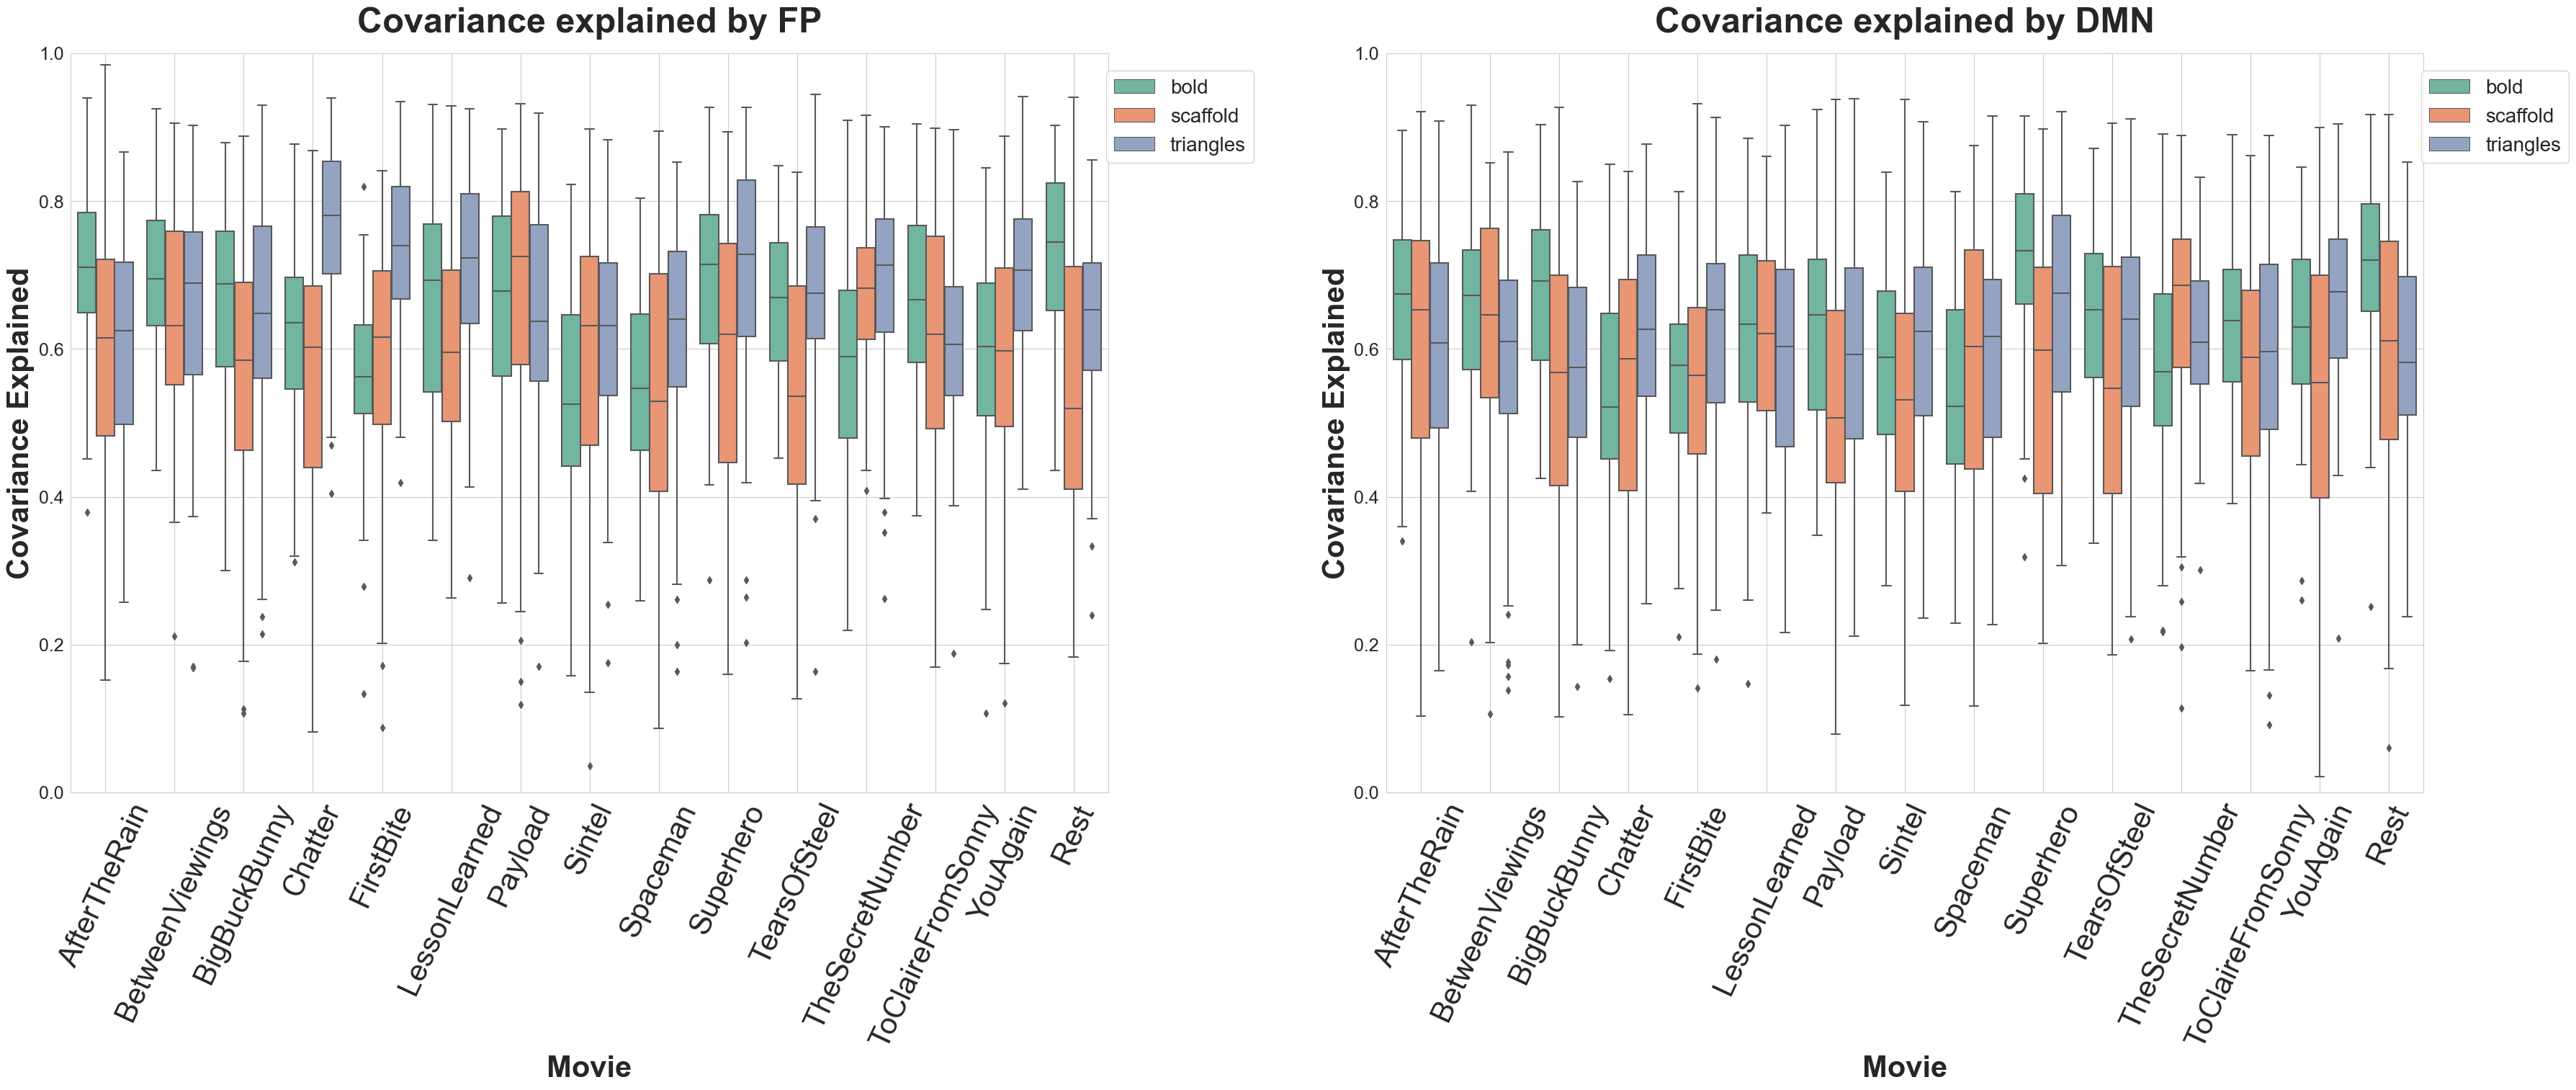

/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_15855/4105787788.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=18)
/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_15855/4105787788.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=18)


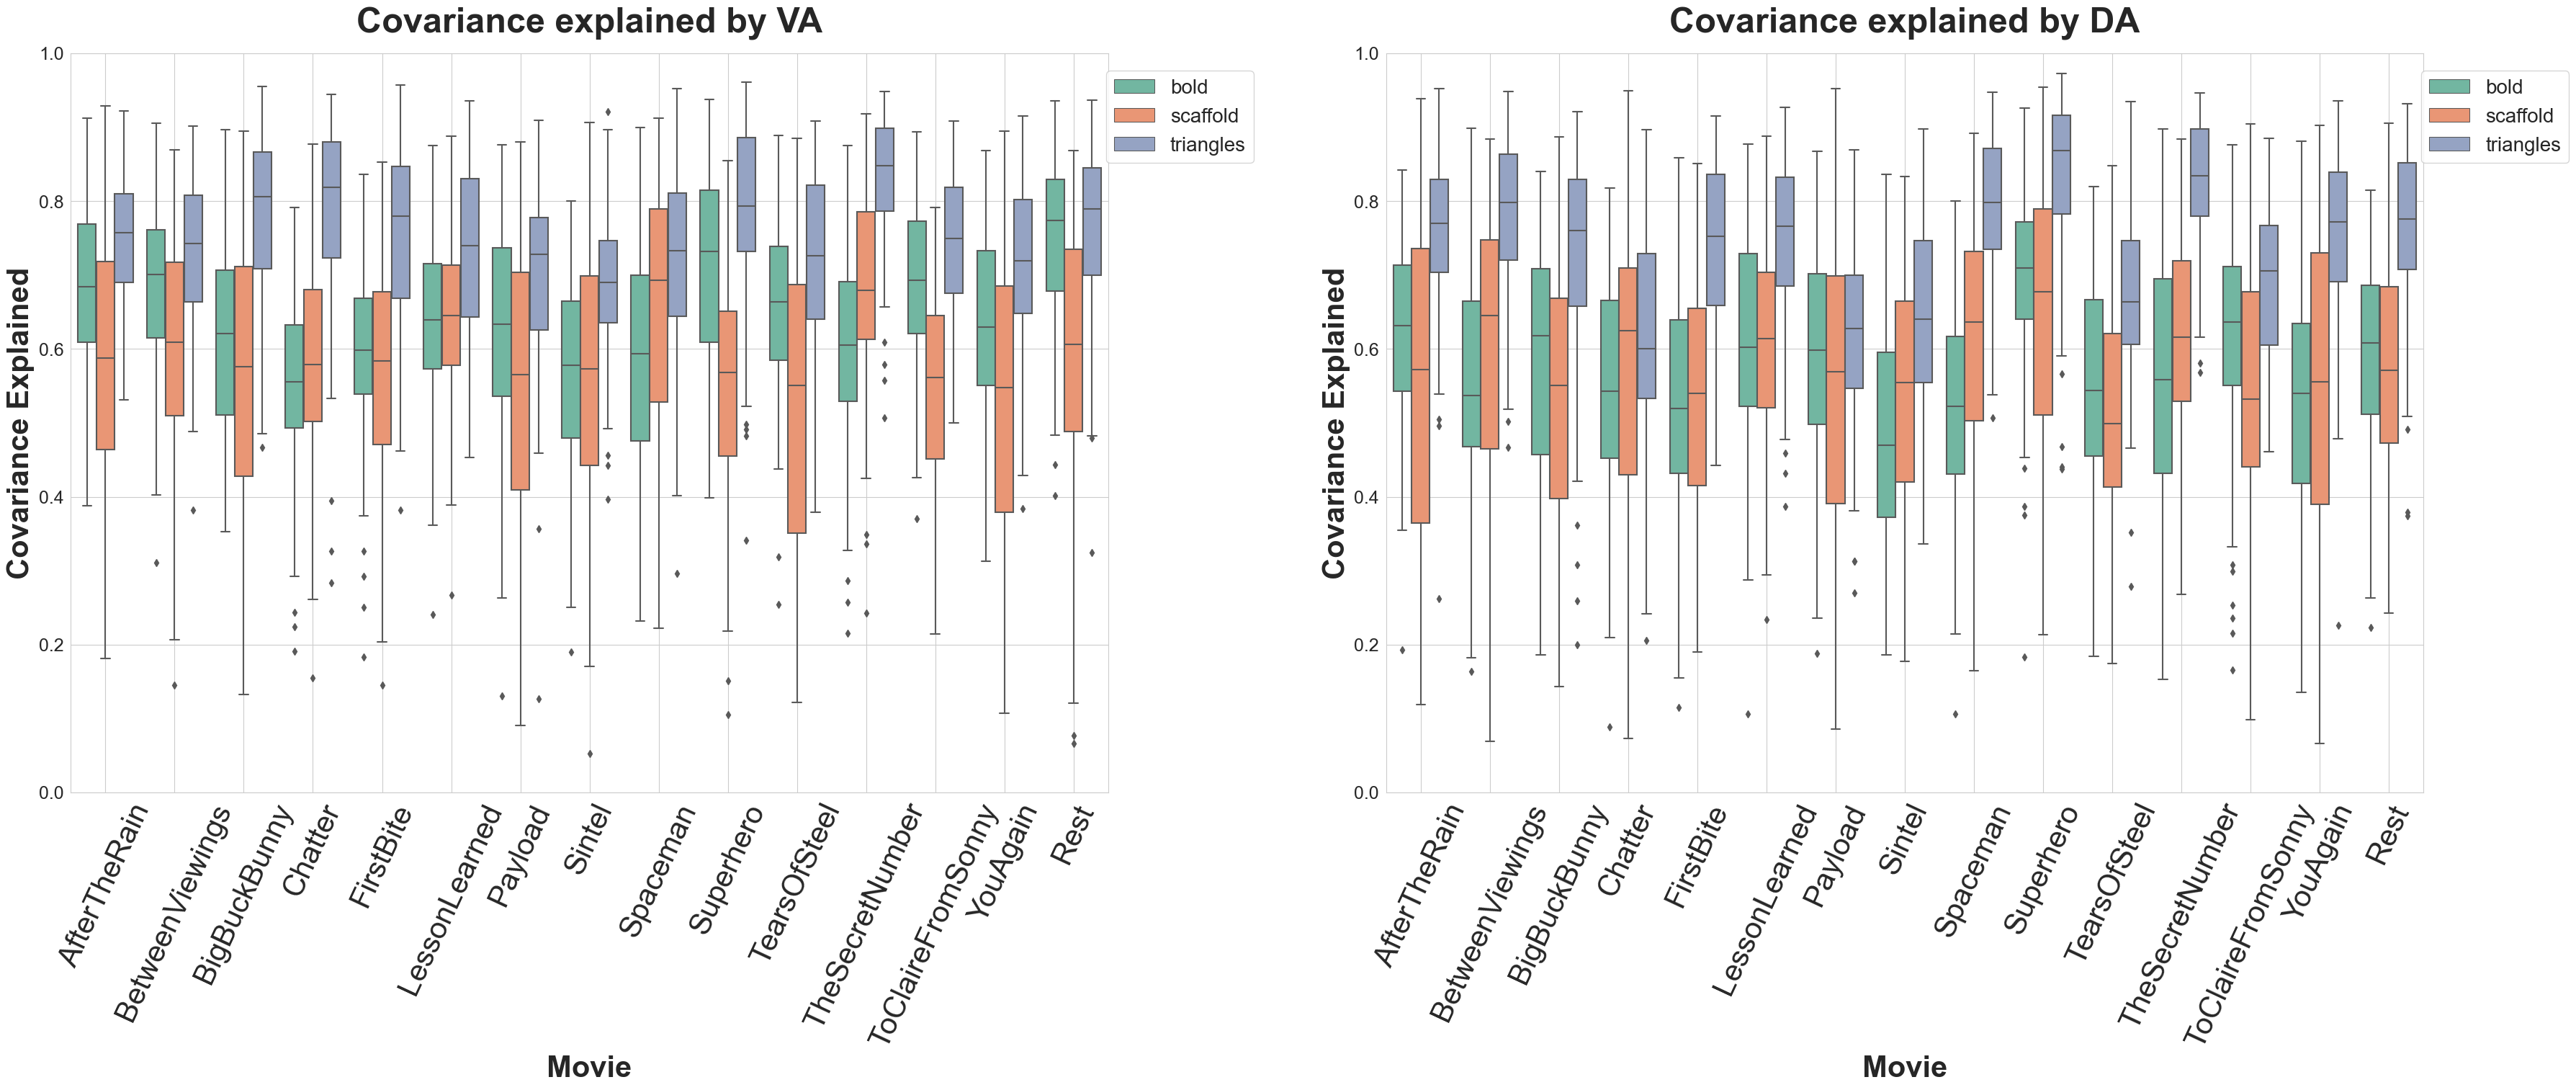

/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_15855/4105787788.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=18)
/var/folders/4y/lsm2ngkn0cjfbpd_6bmg0__80000gn/T/ipykernel_15855/4105787788.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=18)


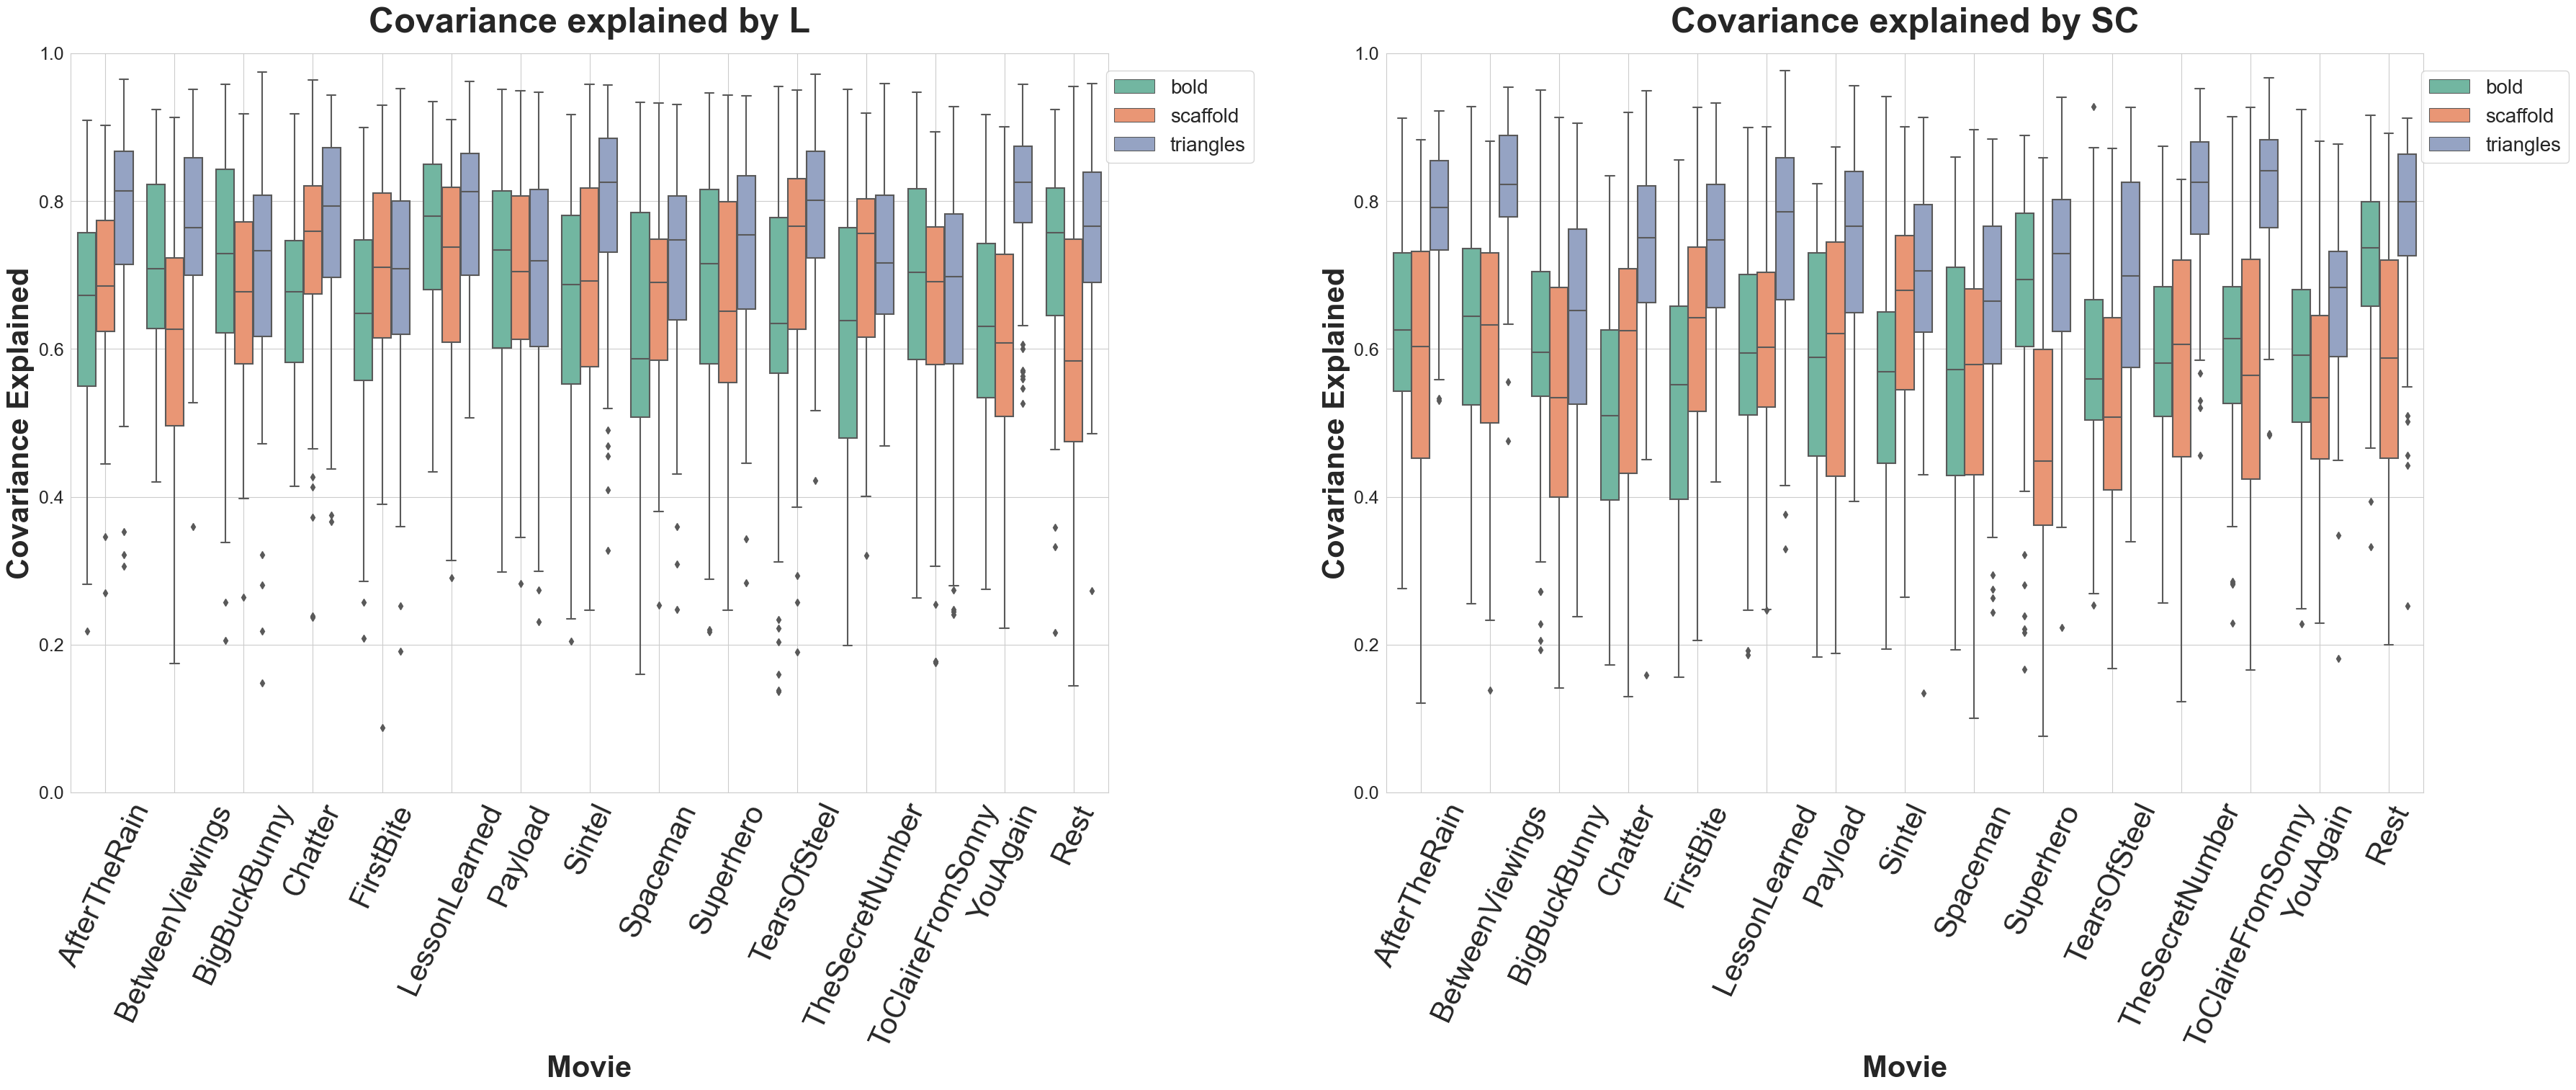

In [22]:
def plot_fn(df_bootstrap, networks):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(40, 15))
    palette = sns.color_palette("Set2")
    fig.tight_layout(pad=25)

    order_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 
                'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 
                'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain', 'Rest']

    for i, network in enumerate(networks):
        network_df = df_bootstrap[df_bootstrap['Region'] == networks[i]]
        sns.boxplot(network_df, ax = axes[i], x='Movie', y='Covariance Explained', hue='Type', order = order_movies, palette = palette)

        axes[i].grid(axis='x')
        axes[i].set_title(network, fontsize=25, fontweight='bold')
        axes[i].set_xlabel('Movie', fontsize=30, fontweight='bold')
        axes[i].set_ylabel('Covariance Explained', fontsize=30, fontweight='bold')
        axes[i].set_xticklabels(axes[0].get_xticklabels(), rotation=65, fontsize=30)
        axes[i].set_ylim(0, 1.0)
        axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=18)
        axes[i].legend(loc='upper right', bbox_to_anchor=(1.15, 0.99), fontsize=20)
        #else:
            # remove the legend
            #axes[i].get_legend().remove()

        axes[i].set_title(f'Covariance explained by {networks[i]}', fontsize=35, fontweight='bold', y = 1.02)
    #fig.suptitle(f'Covariance explained by the YEO functional networks', fontsize=35, fontweight='bold')
    plt.subplots_adjust(top=0.93)

    plt.show()

plot_fn(df_bootstrap, ['VIS', 'SM'])

plot_fn(df_bootstrap, ['FP', 'DMN'])

plot_fn(df_bootstrap, ['VA', 'DA'])

plot_fn(df_bootstrap, ['L', 'SC'])

### **Difference between triangles and bootstrap**

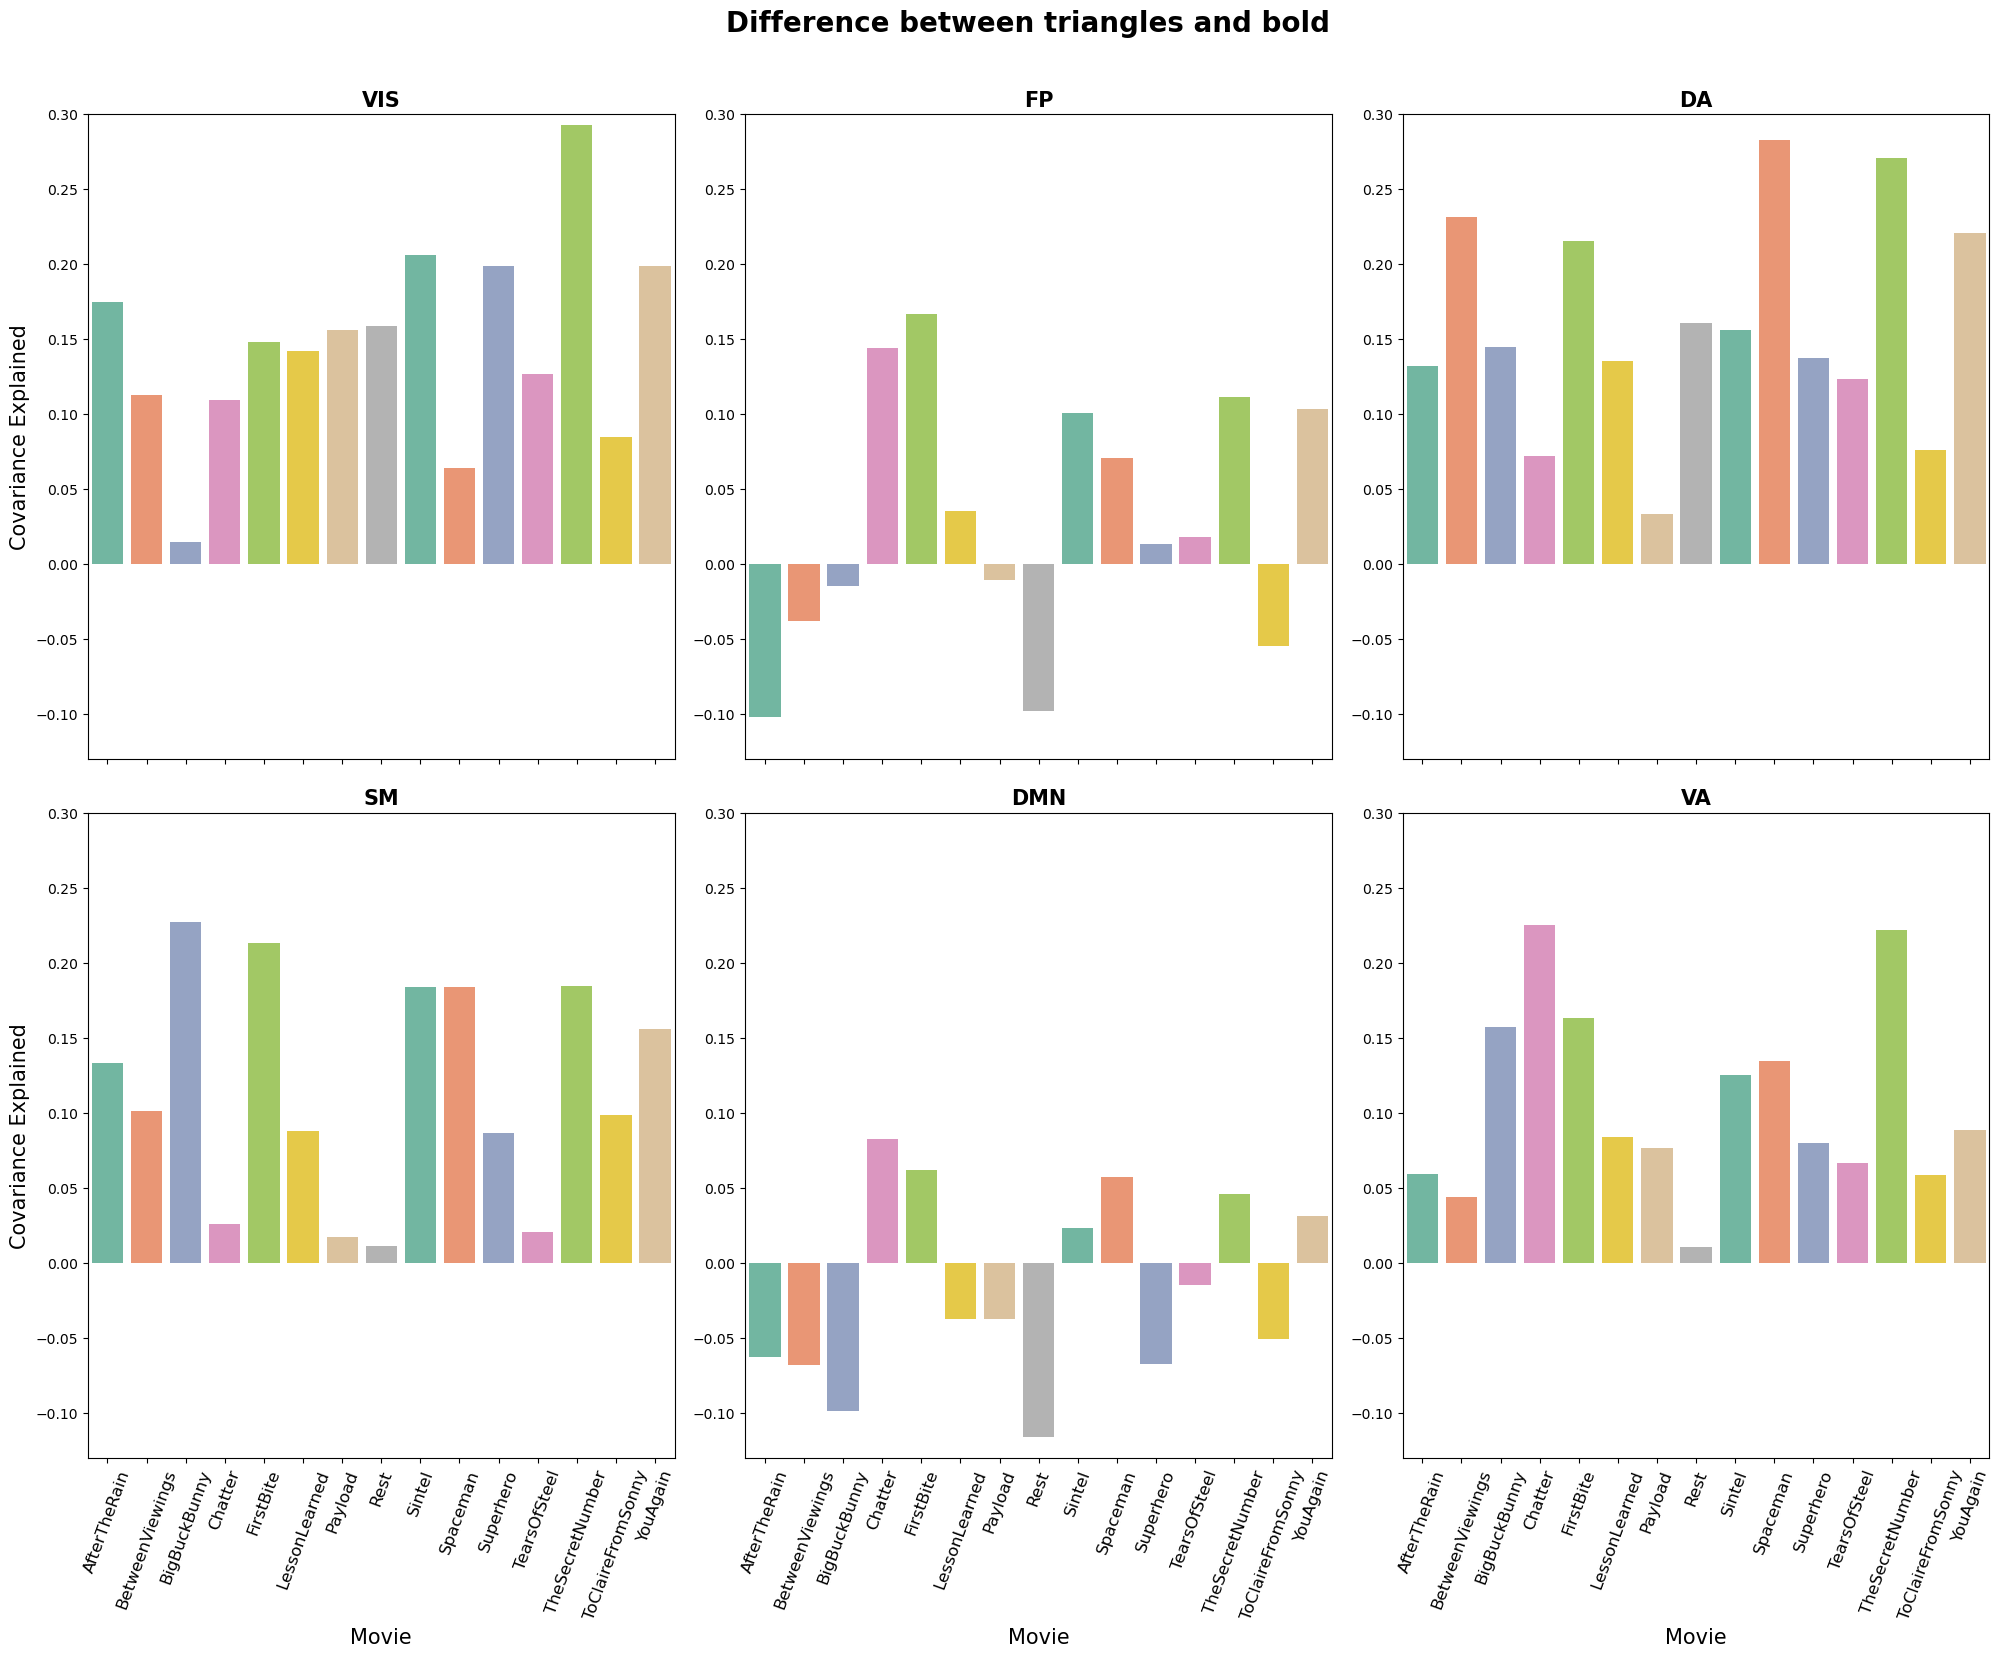

In [ ]:
def plot_diff(df_bootstrap, networks):

    # create 2 subplots
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(20, 15))
    palette = sns.color_palette("Set2")
    fig.tight_layout(pad=2)
    
    for i, network in enumerate(networks):
        row = i % 2
        col = i // 2

        network_df = df_bootstrap[df_bootstrap['Region'] == network]
        network_df = network_df.groupby(['Movie', 'Type'])[['Covariance Explained']].mean().reset_index()
        bold_mean = np.array(network_df[network_df['Type'] == 'bold']['Covariance Explained'])
        triangles_mean = np.array(network_df[network_df['Type'] == 'triangles']['Covariance Explained'])

        difference = triangles_mean - bold_mean

        sns.barplot(x = network_df['Movie'].unique(), y = difference, ax = axes[row, col], palette = palette)
        axes[row, col].set_title(f'{network}', fontsize=15, fontweight='bold')
        if row == 1:
            axes[row, col].set_xlabel('Movie', fontsize=15)
            axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=70, fontsize=12)
        else:
            axes[row, col].set_xlabel('')
            axes[row, col].set_xticklabels('')
        if col == 0:
            axes[row, col].set_ylabel('Covariance Explained', fontsize=15)

        # set the range of the yaxise
        axes[row, col].set_ylim(-0.13, 0.3)

    fig.suptitle('Difference between triangles and bold', fontsize=20, fontweight='bold', y=1.00)
    plt.subplots_adjust(top=0.93)

    plt.show()

plot_diff(df_bootstrap, ['VIS', 'SM', 'FP', 'DMN', 'DA', 'VA'])

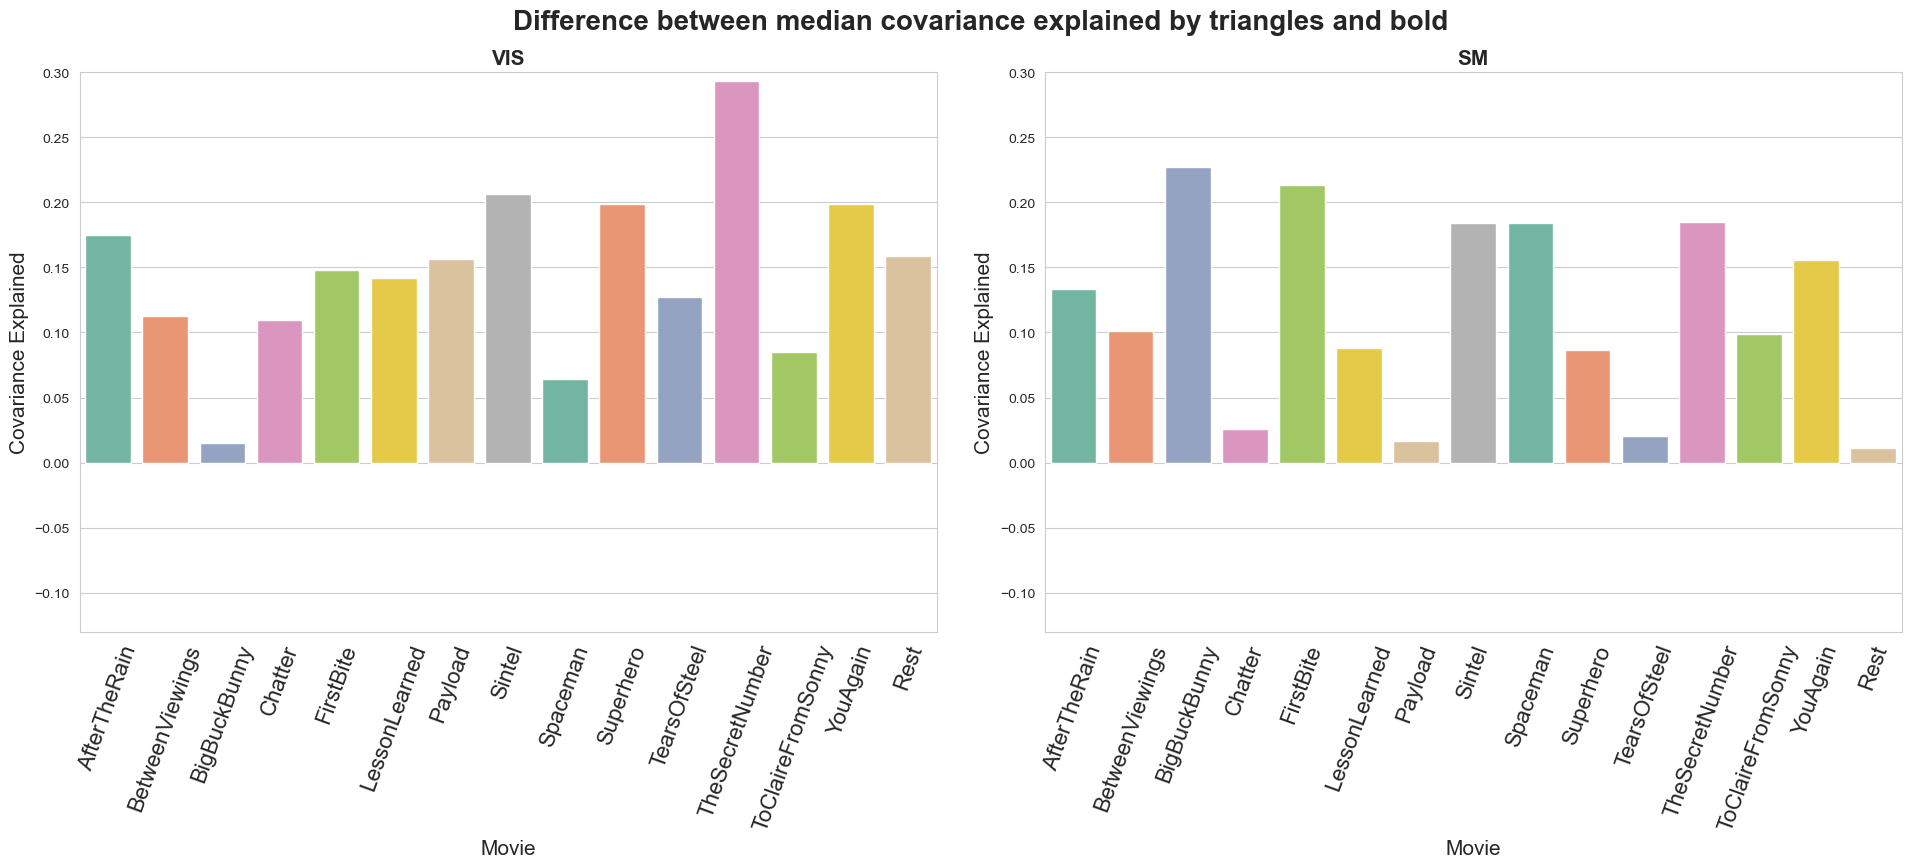

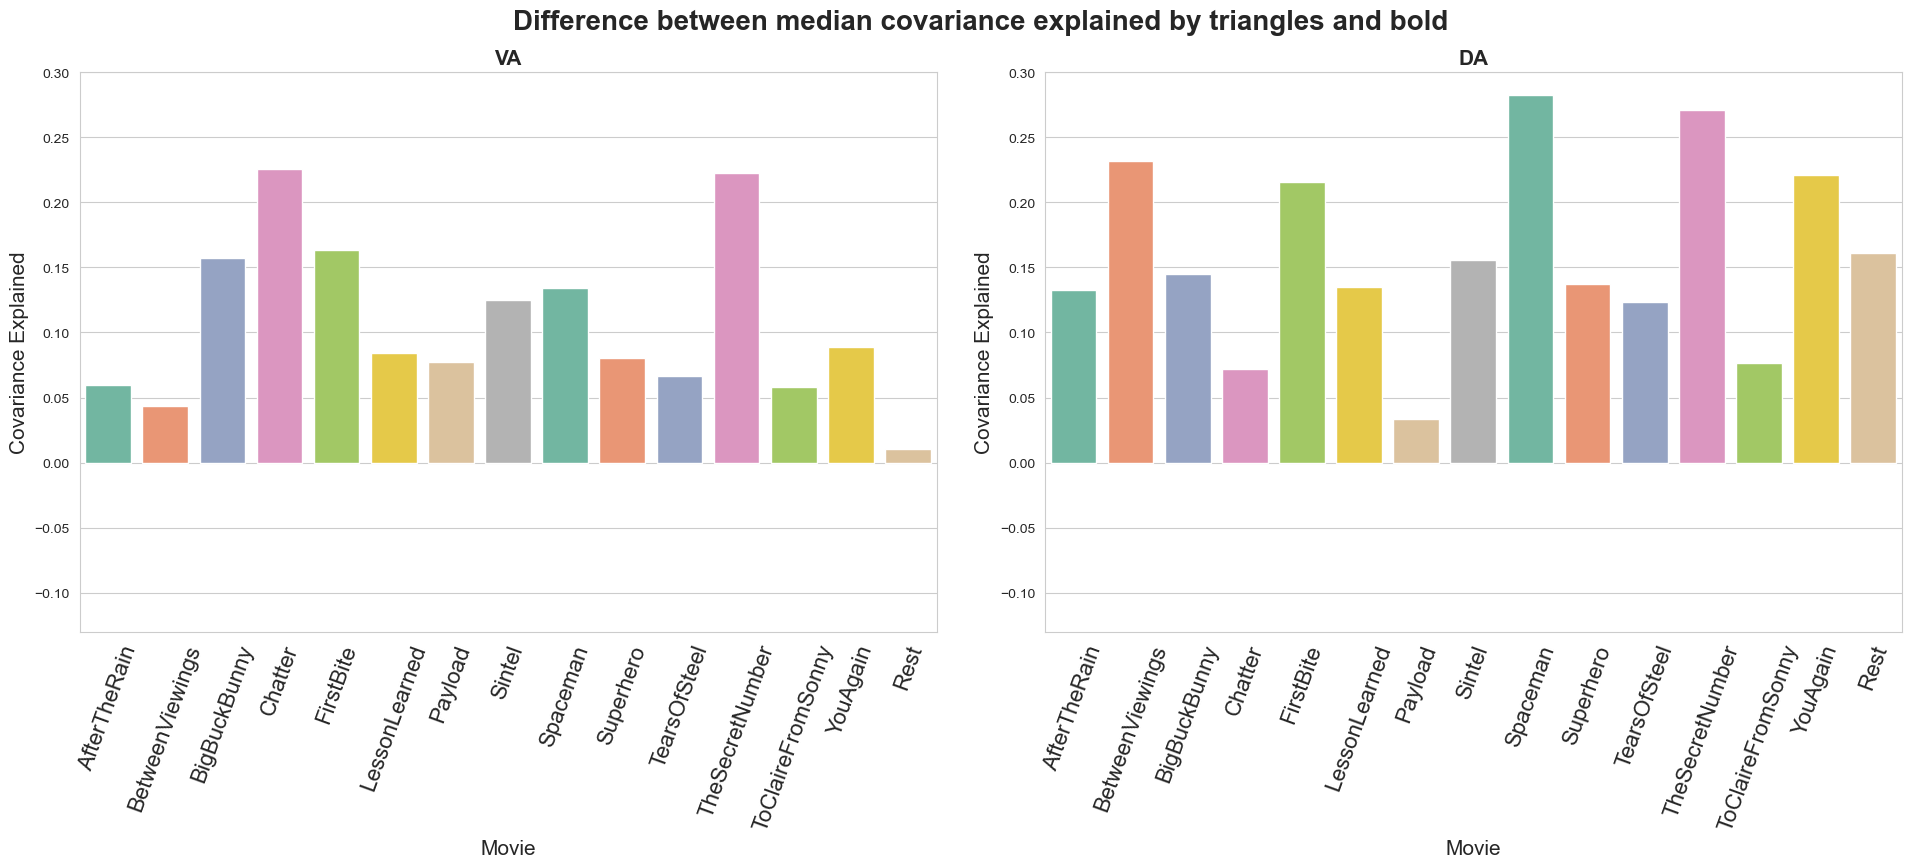

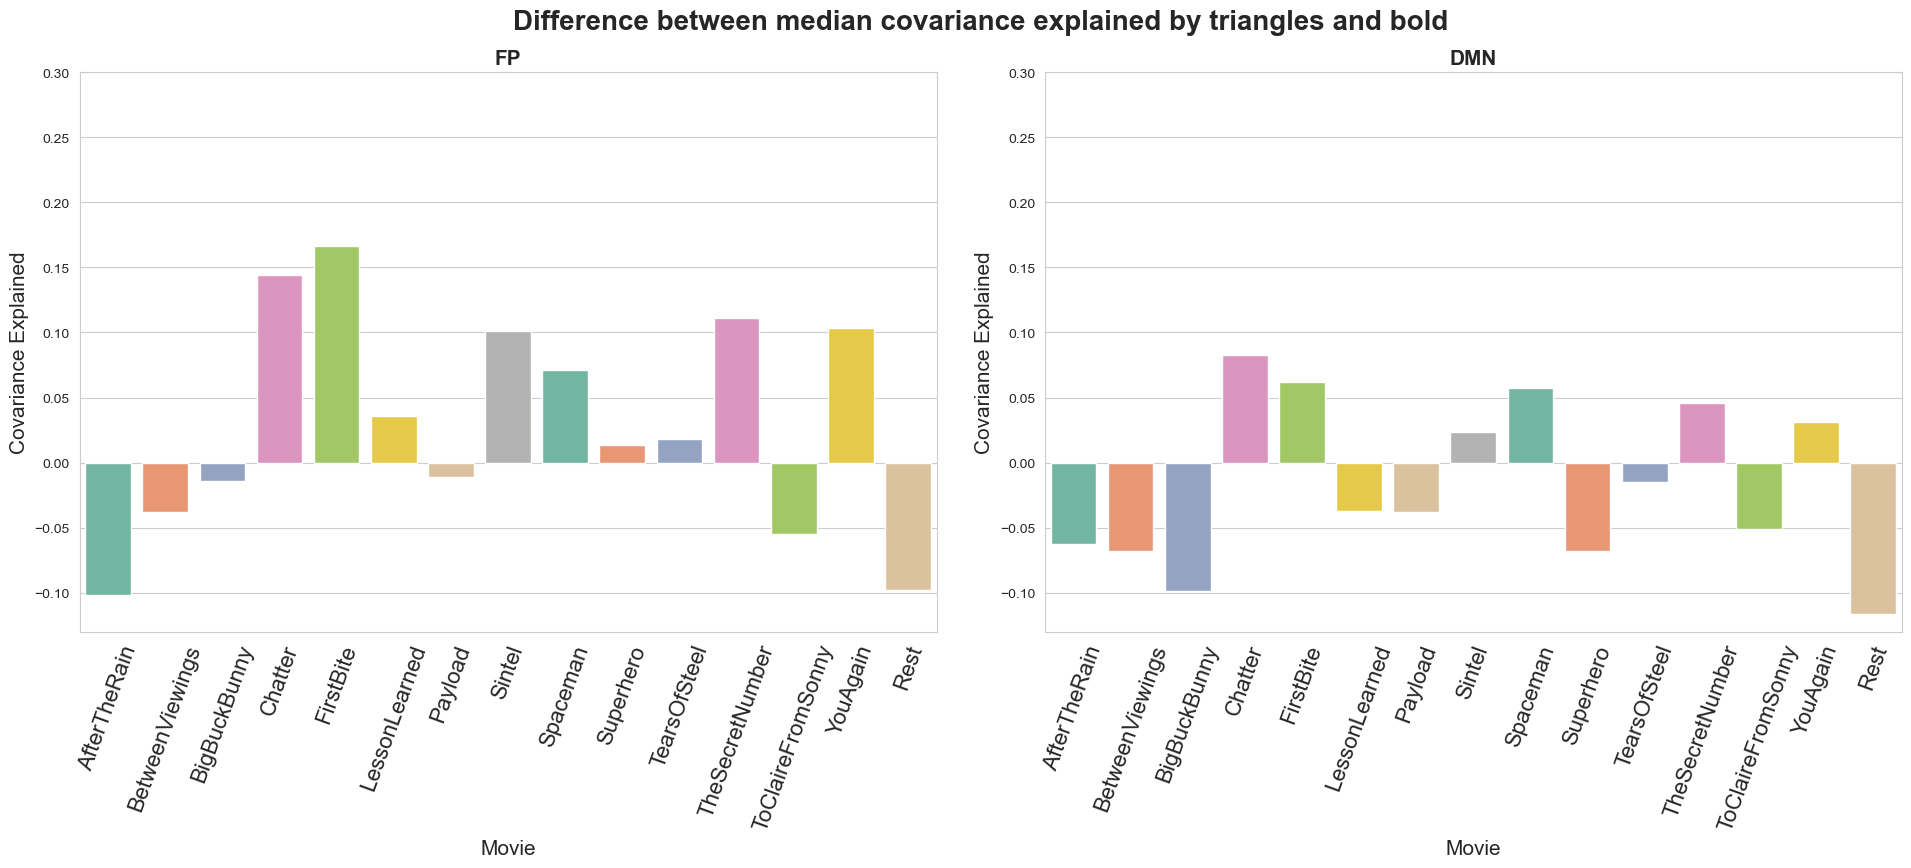

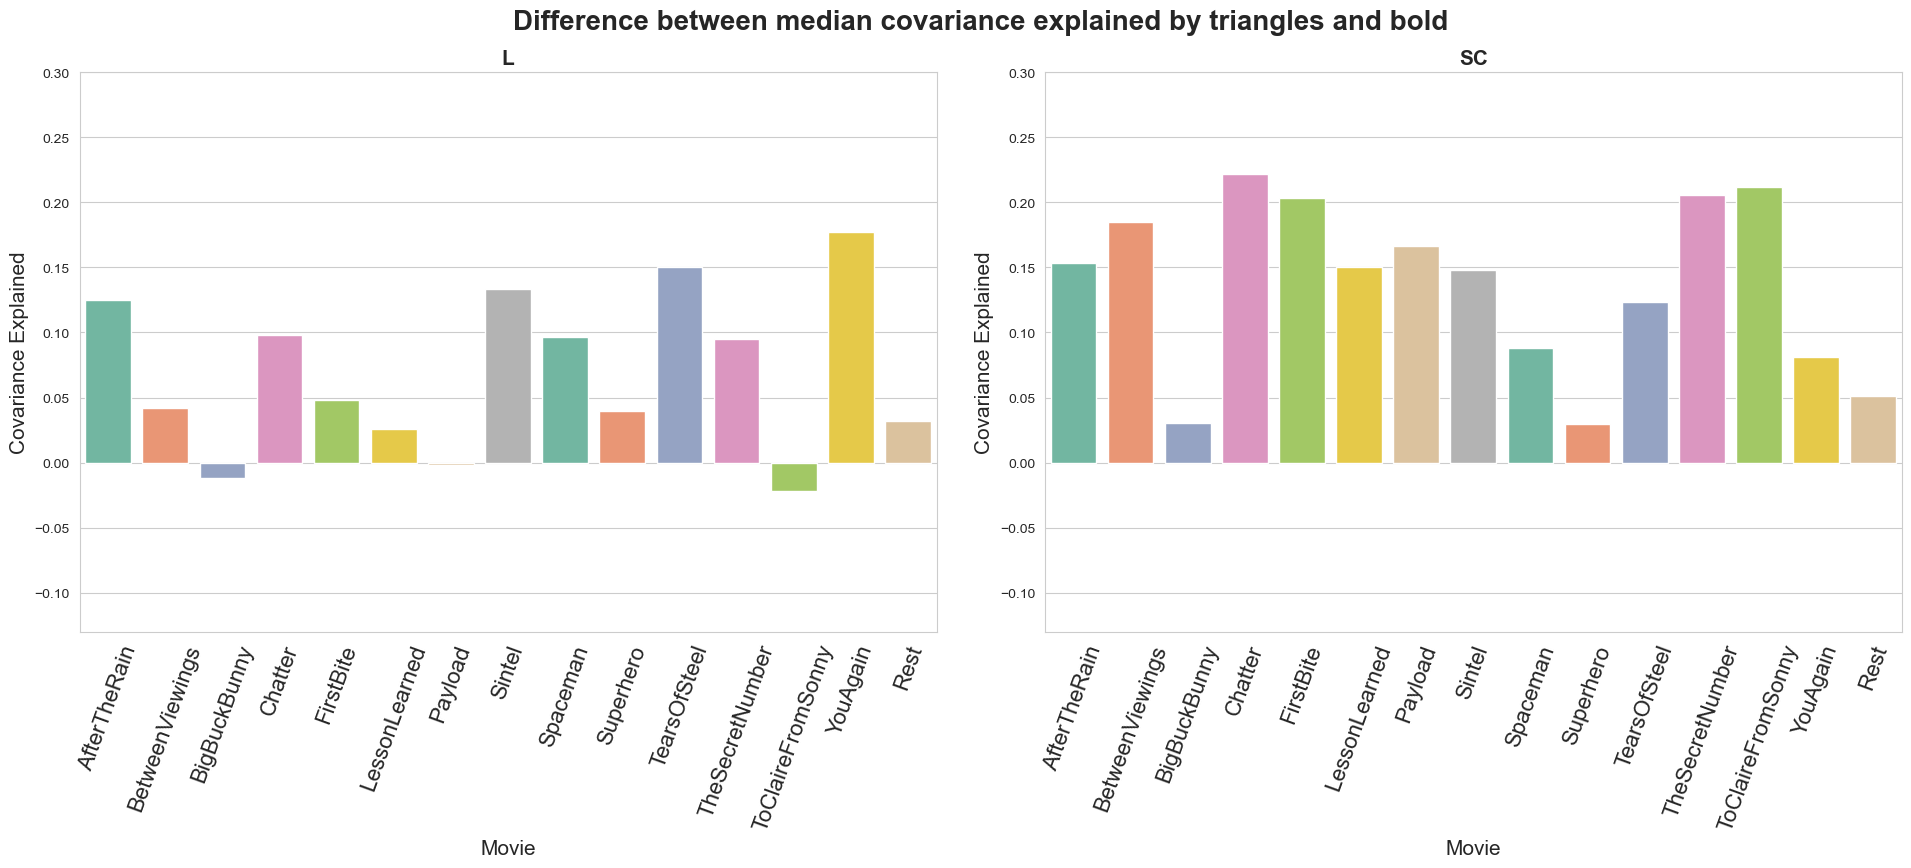

In [30]:
def plot_diff_2(df_bootstrap, networks):

    # create 2 subplots
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 7))
    palette = sns.color_palette("Set2")
    fig.tight_layout(pad=5)

    order_movies = ['AfterTheRain', 'BetweenViewings', 'BigBuckBunny', 'Chatter', 'FirstBite', 
                'LessonLearned', 'Payload', 'Sintel', 'Spaceman', 'Superhero', 'TearsOfSteel', 
                'TheSecretNumber', 'ToClaireFromSonny', 'YouAgain', 'Rest']
    
    for i, network in enumerate(networks):

        network_df = df_bootstrap[df_bootstrap['Region'] == network]
        network_df = network_df.groupby(['Movie', 'Type'])[['Covariance Explained']].mean().reset_index()
        bold_mean = np.array(network_df[network_df['Type'] == 'bold']['Covariance Explained'])
        triangles_mean = np.array(network_df[network_df['Type'] == 'triangles']['Covariance Explained'])

        difference = triangles_mean - bold_mean

        sns.barplot(x = network_df['Movie'].unique(), y = difference, ax = axes[i], palette = palette, order = order_movies)
        #axes[i].grid(axis='y')
        axes[i].set_title(f'{network}', fontsize=15, fontweight='bold')
        axes[i].set_xlabel('Movie', fontsize=15)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=70, fontsize=16)
        axes[i].set_ylabel('Covariance Explained', fontsize=15)

        axes[i].set_ylim(-0.13, 0.3)

    fig.suptitle('Difference between median covariance explained by triangles and bold', fontsize=20, fontweight='bold', y=1.02)
    plt.subplots_adjust(top=0.93)

    plt.show()


plot_diff_2(df_bootstrap, ['VIS', 'SM'])

plot_diff_2(df_bootstrap, ['VA', 'DA'])

plot_diff_2(df_bootstrap, ['FP', 'DMN'])

plot_diff_2(df_bootstrap, ['L', 'SC'])